In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.integrate import odeint

### Parameter

In [2]:
sigma1 = 0.15241082
sigma2 = 0.05499124
sigma3 = 0.18231695

rho1 = 1.9598e-4
rho2 = 0.00128233
rho3 = 7.2193e-6

tau1 = 0.29549754
tau2 = 0.57056221
tau3 = 1.3279e-4

gamma = 1/4
beta = 0.4
r_1 = 0.1
mu = 3.3e-6
eta = 1/2.5 * 0.897
l_B = 3.3e-6 #lambda
psi = 0.00199#0.00265
r_2 = 1/12
delta = 0.28

alpha = 0.071
phi = 1.9685e-5
chi = 0.0031
l = 4.2972e-5
a = 0.8
b = 0.8

### Anfangsbedingung

In [3]:
E = 1711.46463
Q_1 = 9708.15805
I = 9788.46469
Q_2 = 3649881-3642450 #recovered from 12.07-01.07
V = 34715161
S = 70000000 - E - Q_1 - Q_2 - I - V


U = 140000 
D = 1400000
R = 350000
H = 0
L = 70000000 - D - R - H - U

### ODE-System

In [4]:
def ODE(xs, t):
    #time between new restrictions
    timeslot_1 = 589 - 549
    timeslot_2 = timeslot_1 + 689-589
    timeslot_3 = timeslot_1+timeslot_2 + 703-689
    
    if t<(timeslot_1):
            rho = rho1 
            sigma = sigma1 
            tau = tau1 
    elif t>=timeslot_1 and t < timeslot_2:
            rho = rho2 
            sigma = sigma2 
            tau = tau2 
    else:
            rho = rho3
            sigma = sigma3
            tau = tau3
        
    S,E,Q_1,Q_2,I,V,    L,U,D,R,H = xs
    N = S + E + Q_1 + Q_2 + I + V
    Q = Q_1 + Q_2
    
    R_G = a*R/(1+a*R)

    eta_1 = 1/2.5 * 0.897 * (S/(S+V))
    eta_2 = 1/2.5 * 0.103
    eta_3 = 1/2.5 * 0.897 * (V/(S+V))
    
    dS = -beta*(I)/(N-Q) * S - psi*( 1 - (R + tau*(U))/N + D/N ) * S - rho * (1- (R + tau * (U))/N) * S + eta_1 * Q_1
    dE = beta * (I)/(N-Q) * S + beta * delta * (I)/(N-Q) * V - rho * ( 1- (R + tau * (U))/N) * E - gamma * E
    dQ_1 = rho * ( 1- (R + tau * (U))/N) * S + rho * ( 1- (R + tau * (U))/N) * E + rho * ( 1- (R + tau * (U))/N) * V - eta_1 * Q_1 - eta_2 * Q_1 - eta_3 * Q_1
    dQ_2 = sigma * ( 1- R/N) * I + eta_2 * Q_1 - r_2 * Q_2
    dI = gamma * E - sigma * ( 1- R/N) * I - r_1 * I
    dV = r_1 * I + r_2 * Q_2 + eta_3 * Q_1 + psi * ( 1- (R + tau * (U))/N + D/N) * S - beta * delta * (I)/(N-Q) * V - rho * ( 1- (R + tau * (U))/N) * V
    
    dL = -alpha * R/N * L*(1-(I+Q_2)/N) - alpha * U/N * L - alpha * D/N * L*(1+(I+Q_2)/N) + phi * R + phi * H
    dU = alpha * U/N * L-  chi * R_G/N * U *(1-(I+Q_2)/N) - chi * D/N * U*(1+(I+Q_2)/N) - l * U
    dD = alpha * D/N * L*(1+(I+Q_2)/N) + chi * D/N * U*(1+(I+Q_2)/N) - l * D 
    dR = alpha * R/N * L* (1-(I+Q_2)/N) + chi * R_G/N * U*(1-(I+Q_2)/N) - phi * R 
    dH = l * D + l * U - phi * H
    

    return [dS,dE,dQ_1,dQ_2,dI,dV,dL,dU,dD,dR,dH]

### Solution of the ODE-System

In [5]:
x0 = [S, E, Q_1, Q_2, I, V,    #epidemics
      L, U, D, R, H]   #opinion

ts = np.linspace(0,183, 183)
Ps = odeint(ODE, x0, ts)

### Function for the reproduction number of the COVID-19 model

In [6]:
def R0_COVID(R_fraction, U_fraction, D_fraction, rho, tau, sigma):

    stern1 = 1-(R_fraction+tau*U_fraction)
    stern2 = 1-(R_fraction+tau*U_fraction)+D_fraction
    stern3 = 1-R_fraction

    R0_COVID = (beta*gamma*(eta*(mu+delta*psi*stern2)+mu*(mu+delta*psi*stern2+rho*stern1)))/((gamma+mu+rho*stern1)*(eta*(mu+psi*stern2)+mu*(mu+psi*stern2-rho*stern1))*(mu+r_1+sigma*stern3))

    return R0_COVID

### Function for the reproduction number of the opinion model

In [7]:
def R0_Opinion(I, Q2):
    R0_Opinion = np.zeros(183)

    N = 70e6

    for i in range(0, 183, 1):
        fplus = 1 + (I[i] + Q2[i])/N
        fminus = 1 - (I[i] + Q2[i])/N
    
        if (l+mu)/(phi+mu) < fplus/fminus:
            R0_Opinion[i] = (alpha*l)/((l+mu)*mu*N) * fplus
        else:
            R0_Opinion[i] = (alpha*l)/((phi+mu)*mu*N) * fminus

    return R0_Opinion

### Calculation of $R_0$ in the COVID-19 model

In [8]:
t = np.linspace(0, 183, 183)

t1 = np.linspace(0, 40, 40) #days
Radicals1 = Ps[0:40, 9]/70e6
Uncertain1 = Ps[0:40, 7]/70e6
Disapproving1 = Ps[0:40, 8]/70e6
R01_COVID = R0_COVID(R_fraction=Radicals1, U_fraction=Uncertain1, D_fraction=Disapproving1, rho=rho1, tau=tau1, sigma=sigma1)

t2 = np.linspace(40, 140, 100)
Radicals2 = Ps[40:140, 9]/70e6
Uncertain2 = Ps[40:140, 7]/70e6
Disapproving2 = Ps[40:140, 8]/70e6
R02_COVID = R0_COVID(R_fraction=Radicals2, U_fraction=Uncertain2, D_fraction=Disapproving2, rho=rho2, tau=tau2, sigma=sigma2)

t4 = np.linspace(140, 183, 43)
Radicals3 = Ps[140:183, 9]/70e6
Uncertain3 = Ps[140:183, 7]/70e6
Disapproving3 = Ps[140:183, 8]/70e6
R04_COVID = R0_COVID(R_fraction=Radicals3, U_fraction=Uncertain3, D_fraction=Disapproving3, rho=rho3, tau=tau3, sigma=sigma3)

R0_complete = np.append(R01_COVID, np.append(R02_COVID, R04_COVID))

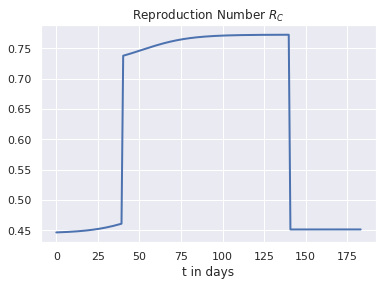

In [9]:
plt.plot(t, R0_complete, linewidth=2.0)

plt.xlabel("t in days")
plt.title("Reproduction Number $R_C$")
plt.show()


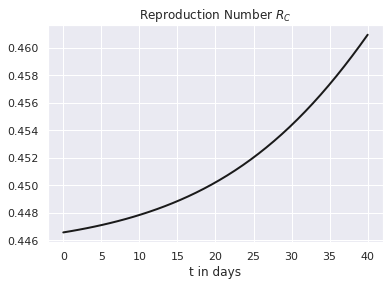

In [10]:
plt.plot(t1, R01_COVID,'k-', linewidth=2.0)

plt.xlabel("t in days")
plt.title("Reproduction Number $R_C$")
plt.show()


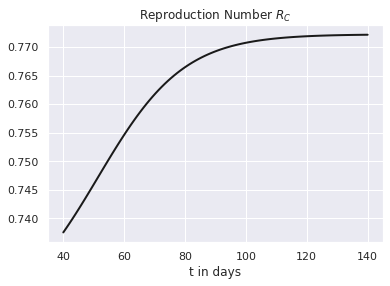

In [11]:
plt.plot(t2, R02_COVID,'k-', linewidth=2.0)

plt.xlabel("t in days")
plt.title("Reproduction Number $R_C$")
plt.show()

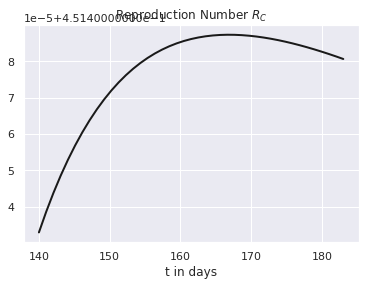

In [12]:
plt.plot(t4, R04_COVID,'k-', linewidth=2.0)

plt.xlabel("t in days")
plt.title("Reproduction Number $R_C$")
plt.show()

### Calculate $R_C$ in information diffusion model

In [13]:
I = Ps[:, 4]
Q_2 = Ps[:, 3]

R0_Opinion_complete = R0_Opinion(I, Q_2)

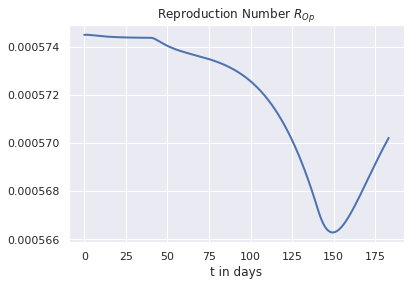

In [14]:
plt.plot(t, R0_Opinion_complete, linewidth=2.0)

plt.xlabel("t in days")
plt.title("Reproduction Number $R_{Op}$")
plt.show()

### Simulations

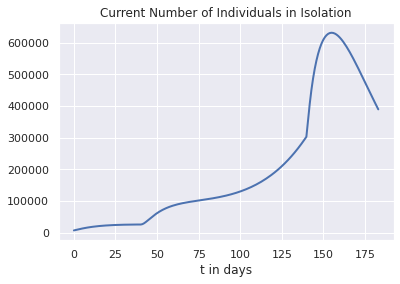

In [15]:
plt.plot(t, Ps[:, 3], linewidth=2.0)

plt.xlabel("t in days")
plt.title("Current Number of Individuals in Isolation")
plt.show()

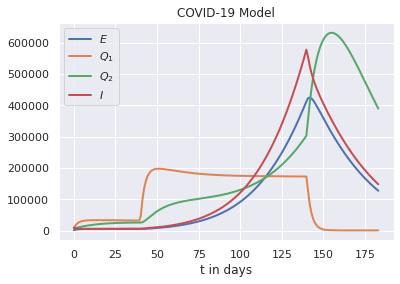

In [16]:
plt.plot(t, Ps[:, 1], linewidth=2.0)
plt.plot(t, Ps[:, 2], linewidth=2.0)
plt.plot(t, Ps[:, 3], linewidth=2.0)
plt.plot(t, Ps[:, 4], linewidth=2.0)

plt.xlabel("t in days")
plt.title("COVID-19 Model")
plt.legend(["$E$", "$Q_1$", "$Q_2$", "$I$"])
plt.show()

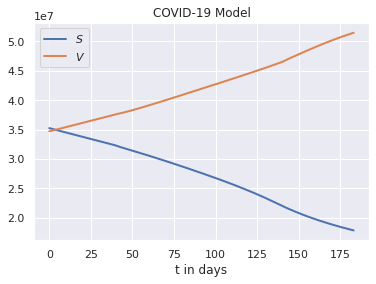

In [17]:
plt.plot(t, Ps[:, 0], linewidth=2.0)
plt.plot(t, Ps[:, 5], linewidth=2.0)

plt.xlabel("t in days")
plt.title("COVID-19 Model")
plt.legend(["$S$", "$V$"])
plt.show()

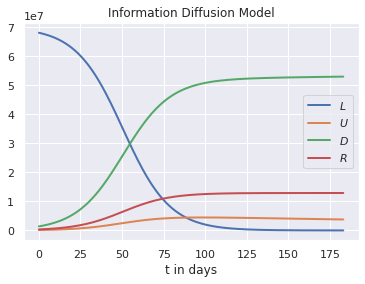

In [18]:
plt.plot(t, Ps[:, 6], linewidth=2.0)
plt.plot(t, Ps[:, 7], linewidth=2.0)
plt.plot(t, Ps[:, 8], linewidth=2.0)
plt.plot(t, Ps[:, 9], linewidth=2.0)

plt.xlabel("t in days")
plt.title("Information Diffusion Model")
plt.legend(["$L$", "$U$", "$D$", "$R$"])
plt.show()

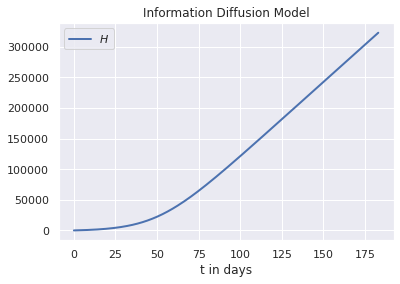

In [19]:
plt.plot(t, Ps[:, 10], linewidth=2.0)

plt.xlabel("t in days")
plt.title("Information Diffusion Model")
plt.legend(["$H$"])
plt.show()

# Sensitivity of the reproduction number

## Write all params in a list

In [20]:
# Parameter definition
R = 0.1
U = 0.4
D = 0.2
gamma = 1/4
beta = 0.4
r1 = 0.1
mu = 3.3e-6
eta = 1/2.5 * 0.897
l = 3.3e-6 #lambda
psi = 0.00199#0.00265
r1 = 0.1
delta = 0.28

sigma1 = 0.1289
sigma2 = 0.0620
sigma3 = 0.1785

rho1 = 2.2543e-4
rho2 = 9.4796e-4
rho3 = 0.001358

tau1 = 0.2863
tau2 = 0.9054
tau3 = 0.9663

stern1_1 = 1-(R+tau1*U)
stern2_1 = 1-(R+tau1*U)+D
stern3 = 1-R

stern1_2 = 1-(R+tau2*U)
stern2_2 = 1-(R+tau2*U)+D

stern1_3 = 1-(R+tau3*U)
stern2_3 = 1-(R+tau3*U)+D

params1 =[R, U, D, rho1, tau1, sigma1, gamma, beta, r1, mu, eta, l, psi, r1, delta, stern1_1, stern2_1, stern3]
params2 =[R, U, D, rho2, tau2, sigma2, gamma, beta, r1, mu, eta, l, psi, r1, delta, stern1_2, stern2_2, stern3]
params3 =[R, U, D, rho3, tau3, sigma3, gamma, beta, r1, mu, eta, l, psi, r1, delta, stern1_3, stern2_3, stern3]

params1_str =["R", "U", "D", "rho1", "tau1", "sigma1", "gamma", "beta",
              "r1", "mu", "eta", "l", "psi", "r1", "delta", "stern1_1", "stern2_1", "stern3"]

In [21]:
def R0_param(params): #R is the radical fraction of the population

    R, U, D, rho, tau, sigma, gamma, beta, r1, mu, eta, l, psi, r1, delta, stern1, stern2, stern3 = params

    R0 = (beta*gamma*(eta*(mu+delta*psi*stern2)+mu*(mu+delta*psi*stern2+rho*stern1)))/((gamma+mu+rho*stern1)*(eta*(mu+psi*stern2)+mu*(mu+psi*stern2-rho*stern1))*(mu+r1+sigma*stern3))

    return R0

In [22]:
def perturb_single_param_2(n, original_params, scale, index):

    mesh = np.linspace(original_params[index]*(1-scale), original_params[index]*(1+scale), n)
    solutions = []
    parameter_diviations = []

    #to see progress write tqdm() around range(n)
    for i in range(n):
        #only choose a single parameter, need to define perturbed_params before we can change an index
        perturbed_params = np.copy(original_params)
        perturbed_params[index] = mesh[i]
        parameter_diviations.append(mesh[i])
        

        R_0 = R0_param(perturbed_params)

        solutions.append(R_0)

    return solutions, parameter_diviations, mesh

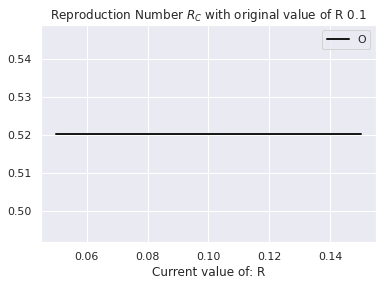

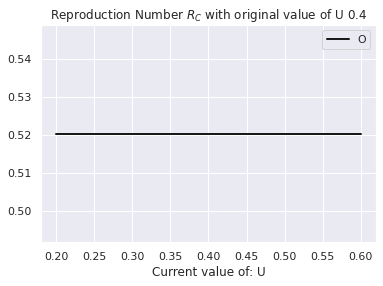

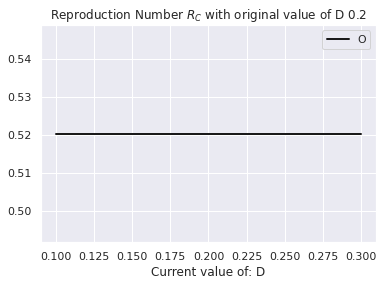

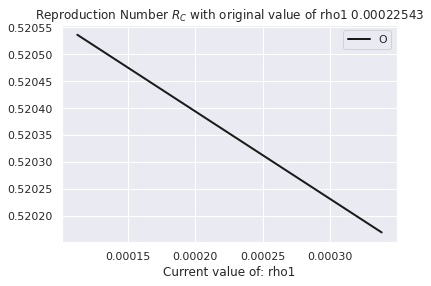

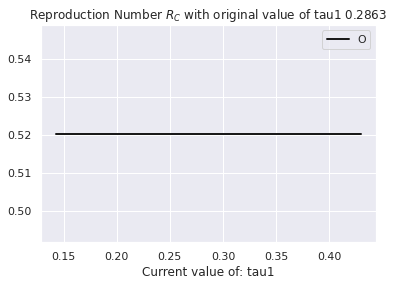

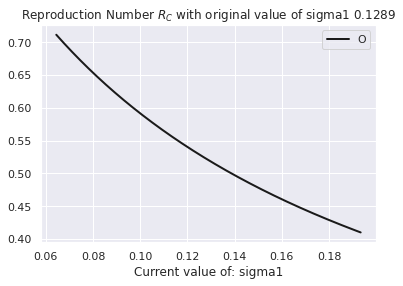

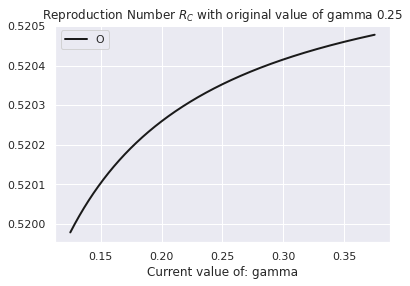

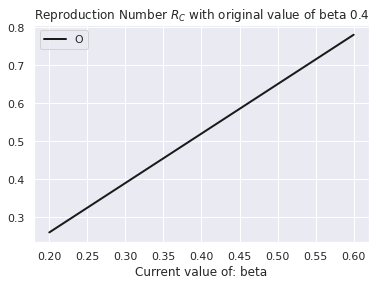

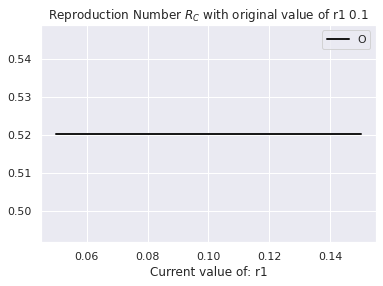

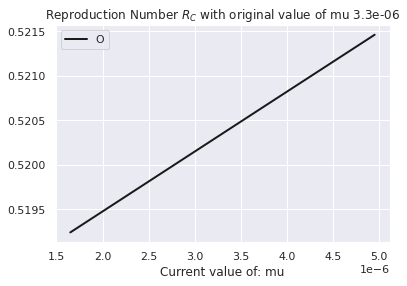

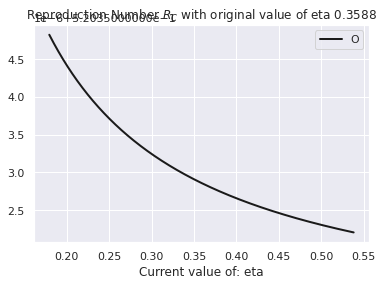

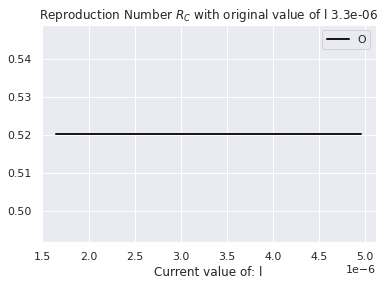

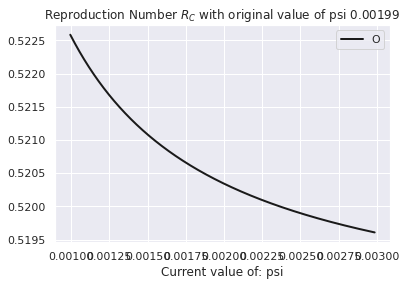

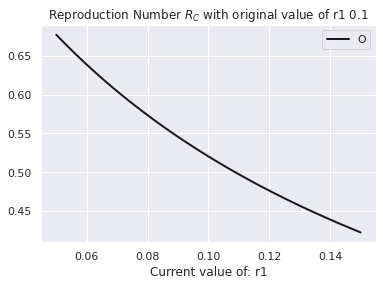

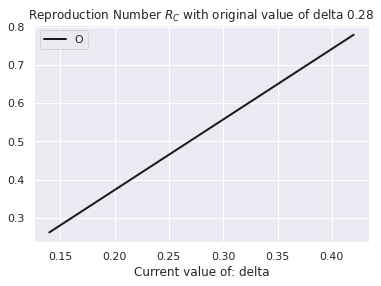

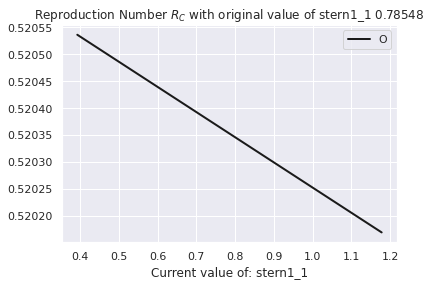

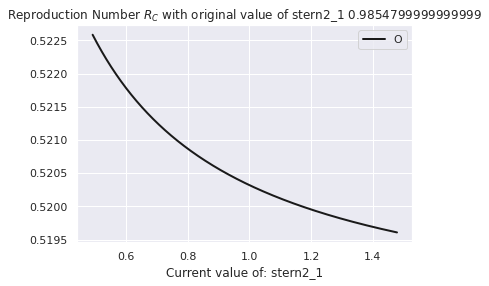

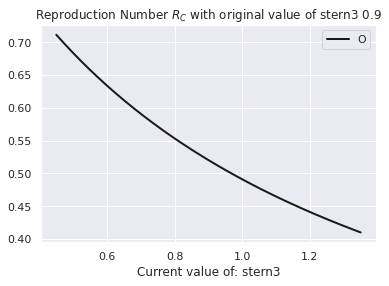

In [23]:
for i in range(len(params1)):
    
    R0_param_dev, param_diviation, mesh = perturb_single_param_2(1000, params1, 0.5, i)

    plt.plot(mesh, R0_param_dev,'k-', linewidth=2.0)
    
    plt.xlabel("Current value of: " + params1_str[i])
    plt.legend("Original value of "  )
    plt.title("Reproduction Number $R_C$ with original value of "+ params1_str[i] + " " + str(params1[i]))
    plt.show()